# Problem Statement
You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

### Outline
- [data](#data)
- [clustering](#clustering)
- [results: cluster properties](#results)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AffinityPropagation, SpectralClustering

<a id = "data"></a>
# data

In [2]:
df = pd.read_csv("results.csv")
display(df.shape)
display(df.head())
display(df.columns)

(31984, 21)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

In [3]:
# null data
display(df.isnull().sum()[df.isnull().sum() > 0])

ctz      30740
state     2576
city         1
dtype: int64

In [5]:
for col in (df == '-').sum()[(df == '-').sum() > 0].index:
    df[col] = df[col].replace('-',None)
    df[col] = df[col].astype('float')

In [25]:
# drop name, bib, ctz, city
X = df[['gender', 'age','official']]
# gender categorical to binary
X['gender'] = np.where(X['gender'] == 'M', 0,1) # Male -> 1
# classifications: hometown (city==Boston)
X['hometown'] = (df['city'] == 'Boston').astype('int')
# normalize
X_norm = (X - X.min()) / (X.max() - X.min())

/home/conner/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/conner/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
X_train_full, X_train_empty = train_test_split(X_norm, test_size=0.5, random_state=42)
X1, X2 = train_test_split(X_train_full, test_size=0.5, random_state=42)
X3, X4 = train_test_split(X_train_empty, test_size=0.5, random_state=42)

In [27]:
display(X_norm.shape)
display(X_train_full.shape)
display(X1.shape)

(31984, 4)

(15992, 4)

(7996, 4)

<a id = "clustering"></a>
# clustering

In [9]:
# k means
def means_eval(n_clusters, X):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    return km.fit(X)

In [10]:
# mean shift
def shift_eval(n_clusters,X):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    return ms.fit(X)

In [11]:
# spectral clustering
def spectral_eval(n_clusters, X):
    sc = SpectralClustering(n_clusters=n_clusters)
    return sc.fit(X)

In [12]:
# affinity propagation
def affinity_eval(n_clusters, X):
    af = AffinityPropagation(damping = .9)
    return af.fit(X)

In [13]:
# evaluation
def silhouette(n_clusters, not_all_models = False):
    models = [means_eval, shift_eval, spectral_eval, affinity_eval]
    if not_all_models:
        models = [means_eval, spectral_eval]
    for model in models:
        print ("\nEvaluating " + model.__name__)
        start_time = time.time()
        sil_scores = [metrics.silhouette_score(Xn, model(n_clusters, Xn).labels_, metric='euclidean') for Xn in [X1,X2,X3,X4]]
        print ("Silhouette score: {:0.3f} +/- {:0.3f}".format(np.mean(sil_scores),np.std(sil_scores)))
        print ("Runtime: {:0.2f}".format(time.time()-start_time))

In [32]:
silhouette(n_clusters = 4)
''' # test out some cluster sizes
for n_clusters in range(6,21,2):
    print ("\n=================================\n{} clusters".format(n_clusters))
    silhouette(n_clusters=n_clusters,not_all_models=True)
''';


Evaluating means_eval
Silhouette score: 0.568 +/- 0.001
Runtime: 9.15

Evaluating shift_eval
Silhouette score: 0.757 +/- 0.000
Runtime: 9.69

Evaluating spectral_eval
Silhouette score: 0.567 +/- 0.001
Runtime: 69.67

Evaluating affinity_eval
Silhouette score: 0.336 +/- 0.006
Runtime: 531.78


<a id = "results"></a>
# results: cluster properties
Since k-means performs the most consistently, lets take a look at each cluster and how they are unique.

In [28]:
# run k-means on the full dataset
n_clusters = 4
km_model = KMeans(n_clusters = n_clusters, random_state = 42)
km_model.fit(X_norm)
# add labels to data for analysis
X_label = X.copy()
X_label['label'] = km_model.labels_

In [29]:
# look at group sizes and short statistics
X_label.groupby('label').mean()

,gender,age,official,hometown
label,,,,
0,1.000000,40.164053,253.720417,0.0
1,0.000000,35.271725,215.398984,0.0
2,0.000000,53.800815,248.551519,0.0
3,0.571567,32.554159,275.378588,1.0


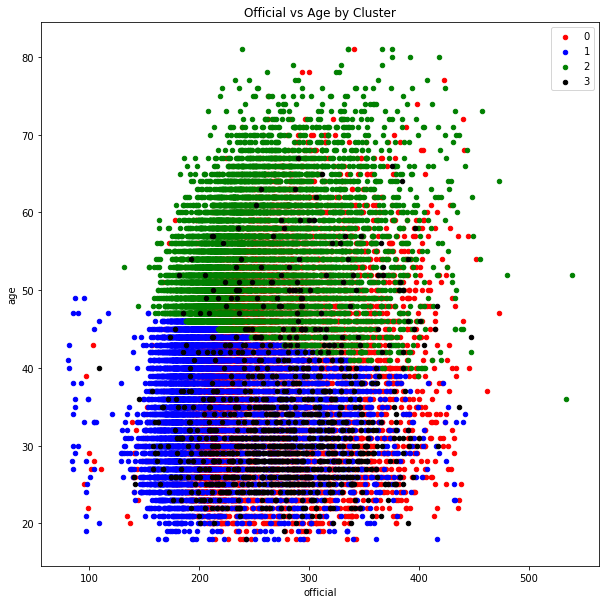

In [58]:
# centers of clusters for gender / age groups
centers = km_model.cluster_centers_ # normalize
fig, ax = plt.subplots(figsize = (10,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
grouped = X_label.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='official', y='age', label=key, color=colors[key])
plt.legend()
plt.xlabel('official')
plt.ylabel('age')
plt.title('Official vs Age by Cluster')
plt.show()

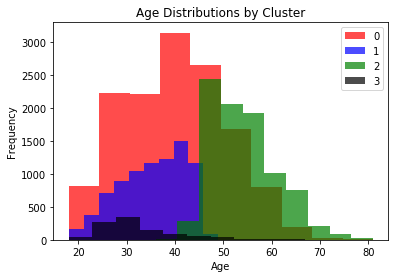

In [76]:
# look at age histograms by cluster
fig,ax = plt.subplots()
for key,group in grouped:
    group['age'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.7)
plt.legend()
plt.xlabel('Age')
plt.title('Age Distributions by Cluster')
plt.show()

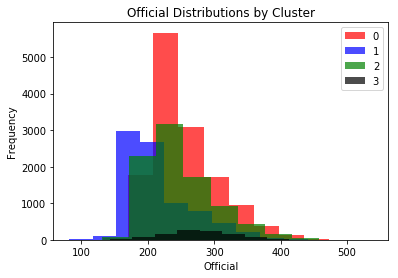

In [77]:
# look at official histograms by cluster
fig,ax = plt.subplots()
for key,group in grouped:
    group['official'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.7)
plt.legend()
plt.xlabel('Official')
plt.title('Official Distributions by Cluster')
plt.show()